In [95]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from datetime import date
from matplotlib.pylab import rc, plot
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import precision_recall_curve, classification_report
from sklearn.model_selection import train_test_split
from scipy import stats


In [96]:
"""Просмотрим данные о работниках"""


engineer_meta = pd.read_pickle("./junior_d_meta.pkl")

"""Junior_d_meta:
CITY - город косметолога
REGION1 - информация о гео-локации
REGION2 - информация о гео-локации
REGION3 - информация о гео-локации
CONTACT_ID - ID инженера
SPECIALTY - специализация косметолога
SEGMENT - сегмент косметолога
"""

'Junior_d_meta:\nCITY - город косметолога\nREGION1 - информация о гео-локации\nREGION2 - информация о гео-локации\nREGION3 - информация о гео-локации\nCONTACT_ID - ID инженера\nSPECIALTY - специализация косметолога\nSEGMENT - сегмент косметолога\n'

In [97]:
engineer_meta

,CITY,REGION1,REGION2,REGION3,CONTACT_ID,SPECIALTY,SEGMENT
0,1,-1,-1,-1,021e1902-2efd-40ce-b3ae-8f43703053f7,0,no segment
2,1,-1,-1,-1,028edc7a-9e21-46c1-b34b-6bcd5477c33b,0,no segment
3,1,-1,-1,-1,037c65bb-d5de-4216-a4ed-83b8661dd70c,0,no segment
4,1,-1,-1,-1,040c709e-bb9f-4402-b9b7-74e3e13ff5f9,0,no segment
5,1,-1,-1,-1,04984e54-4e62-47c1-bb3b-d8a985413f40,0,no segment
...,...,...,...,...,...,...,...
26861,122,53,84,806,292e2fb0-56d6-4a16-86b0-158fcbb23481,2,D2
26862,122,53,84,802,19780ba4-8369-4ff1-a4c8-2a93483119bf,2,E
26863,546,43,189,613,9d733733-d5d9-4b34-a1f4-45c000dca5ec,2,A
26864,644,5,413,57,8f16656d-6bd9-4661-b5b8-6dedc3c6f3ac,2,D2


In [98]:
# отсутствуют не уникальные косметологи в таблице
engineer_meta.CONTACT_ID.nunique()

25461

<AxesSubplot:xlabel='REGION3', ylabel='Count'>

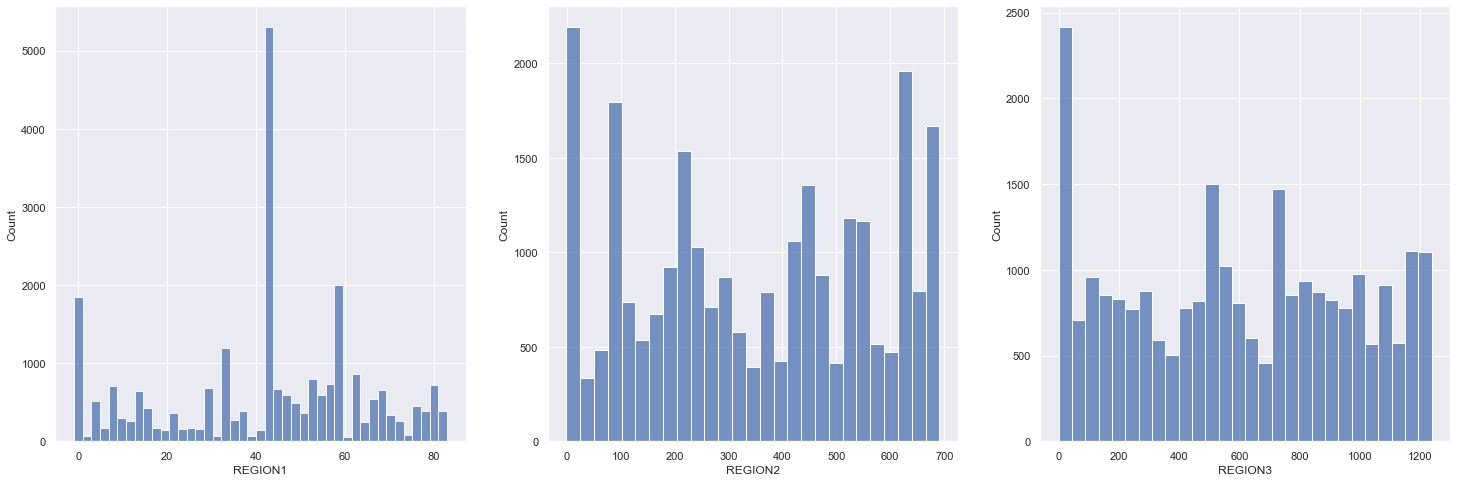

In [99]:
sns.set(rc={'figure.figsize':(25,8)})
fig, axs = plt.subplots(1,3)
sns.histplot(data = engineer_meta, x='REGION1',  kde=False, ax=axs[0])
sns.histplot(data = engineer_meta, x='REGION2',  kde=False, ax=axs[1])
sns.histplot(data = engineer_meta, x='REGION3',  kde=False, ax=axs[2])
# Регион 1 сильно коррелирует с Городом, можно не учитывать. Регион 2,3 - распределены в среднем равномерно, врядли будут значительно играть роль.


<AxesSubplot:xlabel='SEGMENT', ylabel='Count'>

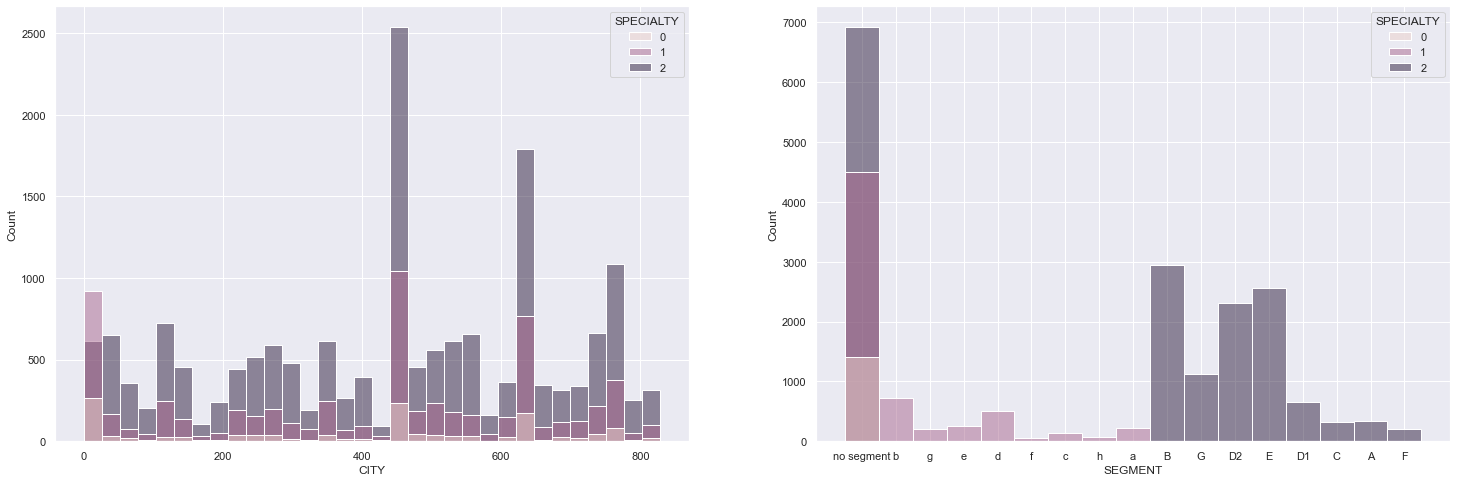

In [100]:
# Можно заметить, что самая распространенная специализация №2, затем идут №1, №0
# Распределение по городам имеет ярко выраженные пики - очевидно столичные города, в провинциях примерно равномерно
fig, axs = plt.subplots(1,2)
sns.histplot(data = engineer_meta,
                        x='CITY',
                        hue='SPECIALTY',
                        kde=False, ax=axs[0])
# Самый популярный способ работы - без четкого сегмента, стоит отметить, что косметологи со специальностью №0 не работают с конкретными сегментами клиентов!
sns.histplot(data = engineer_meta,
                        x='SEGMENT',
                        hue='SPECIALTY',
                        kde=False, ax=axs[1])


In [101]:
# вытащим города с наибольшим количеством стилистов
Top_city = engineer_meta.groupby("CITY", as_index=False).CONTACT_ID.count()
Top_city = Top_city.rename(columns={"CONTACT_ID":"count_users"}).sort_values("count_users", ascending = False).head(5)
Top_city = Top_city.CITY.values.tolist()
Top_city

[450, 629, 1, 504, 210]

In [102]:
# регионы равные -1 относятся только к городу №1, видимо не заполненные анкетные данные
engineer_meta.query('CITY > 1 and REGION1 == "-1"').CITY.count()

0

In [103]:
"""Просмотрим данные о характеристиках писем компании
    Junior_c_meta:
    ID  -  ID email кампании (нет повторов)
    BRANDS - бренды косметики, которые участвуют в рекламной кампании (R 69, A 26, OD 25, O 19, R-OD-O 15)
    KEY_MESSAGE - ключевое сообщение имейла (Other-другое 54, Efficacy-Эффективность 29, Safety-Безопасность 19, Quality-Качество 7, Диагностика 5, Тест 1)
    CONTENT_TYPE - тип контента имейла (Education-Образовательный 70, Engagement-Привлечение партнеров 26, Awareness-Информационное 9, Entertaining-Развлекательное 9)
    CURRENT_STATUS - статус кампании (активный 71/завершенный 42/черновик 41)
"""
company_mail_meta = pd.read_pickle("./junior_c_meta.pkl").rename(columns={'ID':'ID_mail_company'})

In [104]:
company_mail_meta.sort_values("ID_mail_company")

,ID_mail_company,BRANDS,KEY_MESSAGE,CONTENT_TYPE,CURRENT_STATUS
910,93,R,Efficacy,Education,Completed
921,94,O,Quality,Education,Completed
905,97,OD,Quality,Education,Completed
690,98,R,Efficacy,Education,Completed
893,99,O,Efficacy,Education,Completed
...,...,...,...,...,...
565,1201,R,Other,Engagement,Active
560,1203,"R, OD, O",Other,Awareness,Active
299,1205,R,Other,Engagement,Active
127,1207,"R, OD, O",Other,Awareness,Draft


In [105]:
# Черновые проекты не имеют тип контента и ключевого сообщения, за исключением 2х типов писем: ID-557, ID-1207
company_mail_meta.query('CURRENT_STATUS == "Draft"')

,ID_mail_company,BRANDS,KEY_MESSAGE,CONTENT_TYPE,CURRENT_STATUS
3,165,R,None,None,Draft
15,182,R,None,None,Draft
22,557,"R, OD, O",Other,Engagement,Draft
74,416,OD,None,None,Draft
75,266,R,None,None,Draft
81,166,R,None,None,Draft
82,251,O,None,None,Draft
88,318,R,None,None,Draft
91,424,O,None,None,Draft
94,319,R,None,None,Draft


In [106]:
# Вытащим список ID_mail_company из таблицы company_mail_meta для сравнения с ID_mail_company отправленных писем, 
# лишние в последних двух можно убрать, так как по ним нет никакой мета информации.
check_list_id = company_mail_meta.query('CURRENT_STATUS != "Draft"').ID_mail_company.values.tolist()

In [107]:
"""Просмотрим отправленные письма:
    Junior_e_send:
    CONTACT_ID - ID косметолога
    ASSET_ID - ID имейла
    ACTIVITY_TYPE - действие над имейлом
    ACTIVITY_DATE - время совершения действия
    CAMPAIGN_ID - ID email кампании
"""
company_mail_send = pd.read_pickle("./junior_e_send.pkl").rename(columns={'CAMPAIGN_ID':'ID_mail_company'})

In [108]:
company_mail_send.sort_values("ID_mail_company", ascending=False)

,CONTACT_ID,ASSET_ID,ACTIVITY_TYPE,ACTIVITY_DATE,ID_mail_company
135606,61483a91-4dfa-41b1-8ba9-4d84f264a82e,1292,EmailSend,2021-05-29 03:30:20.933,1468.000000000
134956,008407a9-cd68-4e37-9b8e-6eaa1d51299e,1292,EmailSend,2021-05-29 03:30:20.853,1468.000000000
134970,1c6bea78-490a-4271-9f54-25c3e92a61e1,1292,EmailSend,2021-05-29 03:30:19.433,1468.000000000
134969,e9f66deb-1852-4b81-9b82-d2d16bc656ed,1292,EmailSend,2021-05-29 03:30:20.933,1468.000000000
134968,ce8b093b-a64f-4130-9708-a46a48d60493,1292,EmailSend,2021-05-29 03:30:19.433,1468.000000000
...,...,...,...,...,...
50136,ed6f52b2-4b09-46f0-ad0a-0142e378e0ba,None,None,None,None
50137,a3bd9a33-7654-40b5-ae80-945bb5271972,None,None,None,None
50138,5051a6e5-09af-43e6-94af-c362cc21e929,None,None,None,None
50139,cd3753cd-26e7-4bf9-96e6-7283f422557d,None,None,None,None


In [109]:
# пустые строки в таблице отправленых писем вероятно возникли по причине сбоя в отправке - полезной информации не несут, значит можно их удалить!
company_mail_send.isnull().sum()

CONTACT_ID             0
ASSET_ID           23145
ACTIVITY_TYPE      23095
ACTIVITY_DATE      23095
ID_mail_company    23095
dtype: int64

In [110]:
company_mail_send = company_mail_send.fillna(0)
company_mail_send = company_mail_send.query('ID_mail_company > 0')


In [111]:
company_mail_send['ASSET_ID'] = company_mail_send.ASSET_ID.astype(int)
company_mail_send['ID_mail_company'] = company_mail_send.ID_mail_company.astype(int)

In [112]:
# Как видно у всех строк с ASSET_ID=0 был сбой отправки в один момент времени - полезной информации нет, можно удалять.
company_mail_send.query('ASSET_ID == 0')

,CONTACT_ID,ASSET_ID,ACTIVITY_TYPE,ACTIVITY_DATE,ID_mail_company
27755,053bd52e-dbd7-47c1-8a50-8648952ffa03,0,EmailSend,2021-05-01 00:00:00.183,686
27966,06505016-ff6c-490e-8684-4185877f1958,0,EmailSend,2021-05-01 00:00:00.183,686
28005,0321928a-9ca4-4fae-b9e0-8d6ae9b0b48a,0,EmailSend,2021-05-01 00:00:00.183,686
28254,048ae0fa-a55f-45e9-b0f6-93d7f59b962d,0,EmailSend,2021-05-01 00:00:00.183,686
29251,032eb5be-25c8-42c9-87f1-8925cc79a378,0,EmailSend,2021-05-01 00:00:00.183,686
29255,05f8d0ed-21a9-484c-8a9d-531e79a05c3a,0,EmailSend,2021-05-01 00:00:00.183,686
30092,05532b4a-de8e-4d15-9b2b-fcf54be2f23b,0,EmailSend,2021-05-01 00:00:00.183,686
30464,05dc8ce1-42dc-4b5f-afbd-514acec2d465,0,EmailSend,2021-05-01 00:00:00.183,686
30705,037d0cea-0f9f-4ef7-bf06-b32d7aafba9c,0,EmailSend,2021-05-01 00:00:00.183,686
30709,04479c75-ec78-4fb6-900f-b85496ac2923,0,EmailSend,2021-05-01 00:00:00.183,686


In [113]:
#убираем все путсые id
company_mail_send = company_mail_send.query('ASSET_ID > 0')

In [114]:
#convert to datetime format date column
company_mail_send['ACTIVITY_DATE'] = pd.to_datetime(company_mail_send.ACTIVITY_DATE, infer_datetime_format=True)

In [115]:
# добавили колонки с нужными мерами времени
company_mail_send["date_send"] = company_mail_send.ACTIVITY_DATE.dt.date
company_mail_send["weekday_send"] = company_mail_send.ACTIVITY_DATE.dt.weekday
company_mail_send["hour_send"] = company_mail_send.ACTIVITY_DATE.dt.hour

In [116]:
# убираем лишнюю колонку с типом действия
company_mail_send = company_mail_send.drop(columns='ACTIVITY_TYPE')

In [117]:
# сохраним полную таблицу для будущих тестов
test_mail_send = company_mail_send.copy()

In [118]:
# убрали id_mail_company о которых нет мета инфы 
company_mail_send  = company_mail_send.loc[company_mail_send.ID_mail_company.isin(check_list_id)]

In [119]:
company_mail_send

,CONTACT_ID,ASSET_ID,ACTIVITY_DATE,ID_mail_company,date_send,weekday_send,hour_send
0,025cb4d9-c8a2-4337-8d52-9fe86642653f,996,2021-04-05 06:47:43.350,1150,2021-04-05,0,6
1,025cb4d9-c8a2-4337-8d52-9fe86642653f,738,2021-02-25 04:02:15.157,976,2021-02-25,3,4
2,025cb4d9-c8a2-4337-8d52-9fe86642653f,740,2021-02-26 03:00:31.030,979,2021-02-26,4,3
3,45997759-279d-4bda-a1d3-f5561cffa025,906,2021-03-17 11:15:00.133,1053,2021-03-17,2,11
4,45997759-279d-4bda-a1d3-f5561cffa025,737,2021-02-25 04:10:16.123,975,2021-02-25,3,4
...,...,...,...,...,...,...,...
117251,037d0cea-0f9f-4ef7-bf06-b32d7aafba9c,1061,2021-04-26 00:00:16.200,1205,2021-04-26,0,0
117252,2354c6a8-d154-4589-bfbc-72d9545d3ea1,1061,2021-04-26 00:00:16.200,1205,2021-04-26,0,0
117253,ea08e448-a8d2-4674-a343-b89e49530756,1061,2021-04-26 00:00:16.200,1205,2021-04-26,0,0
117254,25eb9e2b-0a09-4b1c-a356-f40710a10575,1061,2021-04-26 00:00:16.200,1205,2021-04-26,0,0


<AxesSubplot:xlabel='date_send', ylabel='CONTACT_ID'>

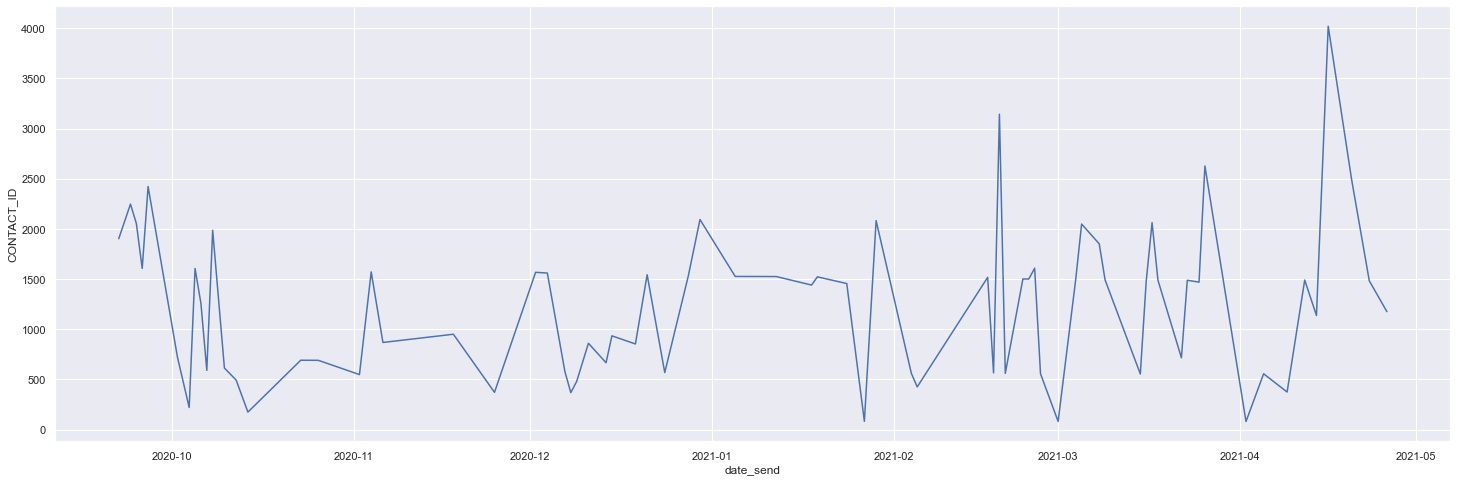

In [120]:
# количество сообщений по дате - можно заметить некоторую волнообразность, глобальный min и max почти не меняются
send_to_date = company_mail_send.groupby('date_send', as_index=False).CONTACT_ID.count()
sns.lineplot(data=send_to_date, x="date_send", y="CONTACT_ID")


In [121]:
# зафиксируем временной интервал, чтобы таблицы посылки и доставки писем были в одном промежутке
max_date = company_mail_send.ACTIVITY_DATE.max()
min_date = company_mail_send.ACTIVITY_DATE.min()

In [122]:
# посчитаем количество уникальных отправленных писем для каждого косметолога 
send_mail = company_mail_send.groupby('CONTACT_ID', as_index=False)\
                              .aggregate({"ASSET_ID": "count"})\
                                .rename(columns = {"ASSET_ID":"send_mail"})\
                                  .sort_values("send_mail", ascending=False)

send_mail

,CONTACT_ID,send_mail
899,3d3a4a61-b30d-4740-a8cb-1dc66749a0aa,60
236,0ebbc60b-0a34-4e9e-ac70-4f85485103e1,60
3123,d3bbf184-4674-4a64-8303-07dac92cea66,60
1673,6e761e39-55ea-47a8-b421-988f80904ccc,60
3003,cb5bfb20-ba27-4faf-a296-e3b3301de42e,60
...,...,...
3207,da3e1714-892e-4bc2-a726-bbb26872edfc,1
3210,daab0713-192a-4b90-ad68-85dad4ce6383,1
2336,9cd8df92-5781-43f9-9228-059cbdf38d8b,1
791,354610c5-61a6-454d-be80-c3b355c364cd,1


In [123]:
"""Просмотрим доставленные письма
    Junior_e_open:
    CONTACT_ID - ID косметолога
    ASSET_ID - ID имейла
    ACTIVITY_TYPE - действие над имейлом
    ACTIVITY_DATE - время совершения действия
"""
received_mail = pd.read_pickle("./junior_e_open.pkl").fillna(0)

In [124]:
# уберем бесполезное поле
received_mail = received_mail.drop(columns='ACTIVITY_TYPE')

In [125]:
# посчитаем кол-во открытых и игнорированных писем для каждого пользователя
received_mail['ASSET_ID'] = received_mail.ASSET_ID.astype(int)

open_mail = received_mail.loc[received_mail.ASSET_ID > 0].groupby('CONTACT_ID', as_index=False).ASSET_ID.count()

open_mail = open_mail.rename(columns={"ASSET_ID":"open_mail"})

ignore_mail = received_mail.loc[received_mail.ASSET_ID == 0].groupby('CONTACT_ID', as_index=False).ASSET_ID.count()

ignore_mail = ignore_mail.rename(columns={"ASSET_ID":"ignore_mail"})

In [126]:
open_mail.sort_values("open_mail", ascending=False)

,CONTACT_ID,open_mail
1361,80ac1a3e-79c1-4484-a4fa-69909569da6a,448
699,4350e95d-0261-42ff-bf4e-04b533d1d861,412
312,1ea0298c-6066-4a3b-af3d-64069a11f488,409
1245,75665bf3-8272-44a7-a353-99bb3d86bee8,378
2470,ed741fdf-daa6-47e3-9f93-08a7b375c586,375
...,...,...
2161,cf0a682d-b7eb-483a-8829-bf05775bd593,1
2150,ce7d43a4-c9e5-4767-ba53-69ce99d1c339,1
2144,ce29ae5c-cf4a-4cbd-b27f-4282e0cbe57d,1
2510,f13f0e66-2c3c-4403-9998-88795141c0b9,1


In [127]:
ignore_mail.sort_values('ignore_mail', ascending=False)

,CONTACT_ID,ignore_mail
0,00039612-1c18-4b23-8a62-e33818ee0550,1
16131,aa14c95a-64b6-4cef-86a7-6ca7b9275bfc,1
16140,aa244033-3110-4dab-bcab-c2b74b71249d,1
16139,aa21e714-8506-402b-8d1f-394a9956e479,1
16138,aa21ced8-d27a-4986-8353-147c46317393,1
...,...,...
8066,540db273-f0f6-400d-87b2-f5be22d12f80,1
8065,540d2d47-c618-45ac-b3d9-259497ef5f09,1
8064,54087c8b-0c78-40c1-b46d-86f297f37c30,1
8063,53fff444-6b5d-4e21-9515-f4c523faa086,1


In [128]:
# множества не пересекаются - следовательно те кто получал и открывал письма, и те кто не открывал разные люди
# также можно заметить, что все кто не открыл письмо сделали это 1 раз, значит не имеют статистической значимости 
# и их можно не учитывать...
open_and_ignore_merge = open_mail.merge(ignore_mail, on='CONTACT_ID', how='inner')
open_and_ignore_merge

,CONTACT_ID,open_mail,ignore_mail


In [129]:
#убираем пустые 
received_mail = received_mail.loc[received_mail.ASSET_ID > 0]
#convert to datetime format date column
received_mail['ACTIVITY_DATE'] = pd.to_datetime(received_mail.ACTIVITY_DATE, infer_datetime_format=True)
#received_mail.loc[received_mail.ACTIVITY_DATE >= min_date and received_mail.ACTIVITY_DATE <= max_date]

received_mail = received_mail.loc[received_mail.ACTIVITY_DATE >= min_date]
received_mail = received_mail.loc[received_mail.ACTIVITY_DATE <= max_date]

In [130]:
# добавим колонки с нужными мерами времени
received_mail["date_send"] = received_mail.ACTIVITY_DATE.dt.date
received_mail["weekday_send"] = received_mail.ACTIVITY_DATE.dt.weekday
received_mail["hour_send"] = received_mail.ACTIVITY_DATE.dt.hour

In [131]:
chance_to_open = send_mail.merge(open_mail, on='CONTACT_ID', how='outer')

In [132]:
# видим что есть случаи когда открытых юзером писем больше чем ему посылали - это может быть по причине множественной регистрации 
# действия "открытия" письма, либо по причине разных временных интервалов учета сообщений для пользователей... 
chance_to_open = chance_to_open.fillna(0)
chance_to_open.open_mail = chance_to_open.open_mail.astype(int)
chance_to_open

,CONTACT_ID,send_mail,open_mail
0,3d3a4a61-b30d-4740-a8cb-1dc66749a0aa,60,0
1,0ebbc60b-0a34-4e9e-ac70-4f85485103e1,60,2
2,d3bbf184-4674-4a64-8303-07dac92cea66,60,1
3,6e761e39-55ea-47a8-b421-988f80904ccc,60,8
4,cb5bfb20-ba27-4faf-a296-e3b3301de42e,60,0
...,...,...,...
3771,da3e1714-892e-4bc2-a726-bbb26872edfc,1,0
3772,daab0713-192a-4b90-ad68-85dad4ce6383,1,0
3773,9cd8df92-5781-43f9-9228-059cbdf38d8b,1,0
3774,354610c5-61a6-454d-be80-c3b355c364cd,1,0


In [133]:
# наблюдаем повторяющиеся ASSET_ID
test_user = received_mail.loc[received_mail.CONTACT_ID == 'fff4405f-0f32-4013-8e9b-dca363ee466d'].sort_values('ACTIVITY_DATE', ascending = True)
# как видно, после очистки от дубликатов - открытых писем стало <= чем посланных\
test_user.drop_duplicates(subset=['ASSET_ID'])

,CONTACT_ID,ASSET_ID,ACTIVITY_DATE,date_send,weekday_send,hour_send
68697,fff4405f-0f32-4013-8e9b-dca363ee466d,218,2020-09-22 16:08:37.193,2020-09-22,1,16
115712,fff4405f-0f32-4013-8e9b-dca363ee466d,229,2020-09-24 14:23:40.873,2020-09-24,3,14
20427,fff4405f-0f32-4013-8e9b-dca363ee466d,233,2020-09-25 07:13:30.497,2020-09-25,4,7
114254,fff4405f-0f32-4013-8e9b-dca363ee466d,239,2020-09-25 13:37:16.917,2020-09-25,4,13
84348,fff4405f-0f32-4013-8e9b-dca363ee466d,231,2020-09-26 14:24:28.420,2020-09-26,5,14
134316,fff4405f-0f32-4013-8e9b-dca363ee466d,230,2020-09-27 05:05:38.843,2020-09-27,6,5
16065,fff4405f-0f32-4013-8e9b-dca363ee466d,264,2020-10-05 15:30:13.390,2020-10-05,0,15
81273,fff4405f-0f32-4013-8e9b-dca363ee466d,270,2020-10-06 12:03:31.993,2020-10-06,1,12
82728,fff4405f-0f32-4013-8e9b-dca363ee466d,263,2020-10-08 05:06:49.573,2020-10-08,3,5
35444,fff4405f-0f32-4013-8e9b-dca363ee466d,291,2020-10-12 04:42:59.857,2020-10-12,0,4


In [134]:
# посчитаем уникальные полученные письма
open_mail = received_mail.groupby('CONTACT_ID', as_index=False).ASSET_ID.nunique()
open_mail = open_mail.rename(columns={"ASSET_ID":"open_mail"})
open_mail.sort_values("open_mail", ascending=False)

,CONTACT_ID,open_mail
1334,9950c90c-be85-49f1-aecc-d909c2a4a31e,55
708,51e8ef0f-e56d-42dc-9bb9-8648158c7749,53
130,0d4c4ae4-1a11-4771-acec-5b5f7fcfc10b,52
463,380fa108-ca95-4953-937c-f10525ed55e9,52
2087,f2f91df2-1cb6-44ad-a8f3-1d2813821fdb,52
...,...,...
942,6b83df92-9026-498c-82f0-3d369071c0df,1
945,6bd687fb-f629-41f1-8aef-97b2e661d054,1
2012,eb13d92b-e556-406b-8d65-56ffd82966c9,1
2014,eb1fe7bb-81dc-4fac-8755-275664435e61,1


In [135]:
chance_to_open = send_mail.merge(open_mail, on='CONTACT_ID', how='outer')

chance_to_open = chance_to_open.fillna(0)

chance_to_open.open_mail = chance_to_open.open_mail.astype(int)

chance_to_open

,CONTACT_ID,send_mail,open_mail
0,3d3a4a61-b30d-4740-a8cb-1dc66749a0aa,60,0
1,0ebbc60b-0a34-4e9e-ac70-4f85485103e1,60,2
2,d3bbf184-4674-4a64-8303-07dac92cea66,60,1
3,6e761e39-55ea-47a8-b421-988f80904ccc,60,4
4,cb5bfb20-ba27-4faf-a296-e3b3301de42e,60,0
...,...,...,...
3771,da3e1714-892e-4bc2-a726-bbb26872edfc,1,0
3772,daab0713-192a-4b90-ad68-85dad4ce6383,1,0
3773,9cd8df92-5781-43f9-9228-059cbdf38d8b,1,0
3774,354610c5-61a6-454d-be80-c3b355c364cd,1,0


In [136]:
# осталось рассчитать вероятность открытия письма, все еще осталась проблема логичности данных - открытых писем больше для некоторых юзеров...
chance_to_open['chance_to_open'] = round(chance_to_open.open_mail/chance_to_open.send_mail,3)
chance_to_open.sort_values('chance_to_open', ascending=False)

,CONTACT_ID,send_mail,open_mail,chance_to_open
3556,c47384b9-8510-4659-b26c-ff0130d80d2c,1,7,7.000
2062,d784396c-0699-42a3-8a75-0ddbbe983f4a,17,26,1.529
2139,55fc4a3a-07ba-43f7-999f-7014998603f8,10,14,1.400
2134,4e31548e-48c0-4516-aac1-ee510399f4e1,11,15,1.364
2114,fdb73fb0-a130-4e1b-ba56-ccad374c5245,14,19,1.357
...,...,...,...,...
2583,dd5cbfa5-96f9-4110-b247-08b56fb0f215,3,0,0.000
2582,dd6a8349-c76d-42b0-91b0-1e1d89ef67d3,3,0,0.000
2579,dd7f2c66-2375-4db2-b9cc-e715e0acb470,3,0,0.000
2578,09d68d2c-7fa4-48a2-8422-a32d7371fb9f,3,0,0.000


In [137]:
# вытащим пользователей с нарушенной логикой сообщений
test_users = chance_to_open.loc[chance_to_open.open_mail > chance_to_open.send_mail].CONTACT_ID.to_list()
chance_to_open.loc[chance_to_open.CONTACT_ID.isin(test_users)]

,CONTACT_ID,send_mail,open_mail,chance_to_open
533,f2f91df2-1cb6-44ad-a8f3-1d2813821fdb,51,52,1.020
561,0d4c4ae4-1a11-4771-acec-5b5f7fcfc10b,51,52,1.020
1119,84694c5f-db3d-4ef7-aa2c-ceb603612434,46,49,1.065
1444,41e0efb8-84fe-400e-9854-c2a37bd729ff,39,44,1.128
1456,ceaca8fa-c072-4fa7-a07d-67bcaaf59617,38,46,1.211
1457,b3561c8e-a923-4341-8608-f11122f2601f,38,48,1.263
1459,1b315005-d890-44b4-a96e-a31f370e7327,38,39,1.026
1483,9b3bd5f7-17e9-4a51-8ae2-551fa471324f,38,42,1.105
1493,3b84b511-1748-4678-ac06-643c9c12e9f9,35,40,1.143
1737,df1be023-f99f-4723-b57d-46e4ec040030,18,21,1.167


In [138]:
# для самого яркого представителя проведем тестирование
# 1) данные по нему в таблице полученных писем
received_mail.loc[received_mail.CONTACT_ID == 'c47384b9-8510-4659-b26c-ff0130d80d2c'].drop_duplicates(subset=['ASSET_ID']).sort_values('ACTIVITY_DATE', ascending = True)

,CONTACT_ID,ASSET_ID,ACTIVITY_DATE,date_send,weekday_send,hour_send
68575,c47384b9-8510-4659-b26c-ff0130d80d2c,218,2020-09-22 15:23:41.567,2020-09-22,1,15
114176,c47384b9-8510-4659-b26c-ff0130d80d2c,386,2020-12-04 10:30:50.200,2020-12-04,4,10
56465,c47384b9-8510-4659-b26c-ff0130d80d2c,453,2020-12-13 18:30:26.450,2020-12-13,6,18
59354,c47384b9-8510-4659-b26c-ff0130d80d2c,454,2020-12-20 18:30:34.327,2020-12-20,6,18
87283,c47384b9-8510-4659-b26c-ff0130d80d2c,455,2020-12-30 16:30:57.627,2020-12-30,2,16
5648,c47384b9-8510-4659-b26c-ff0130d80d2c,608,2021-02-08 03:41:26.380,2021-02-08,0,3
90414,c47384b9-8510-4659-b26c-ff0130d80d2c,653,2021-02-21 18:59:44.817,2021-02-21,6,18


In [139]:
# 2) данные в таблице отправленных писем, ДО очистки от строк, отсутствующих в company_mail_meta 
# как видно теперь - если не очищать таблицу отправленных писем то количество отправленных и полученных сравняется 7:7 
# только вот для этих писем нет мета информации
test_mail_send.loc[test_mail_send.CONTACT_ID == 'c47384b9-8510-4659-b26c-ff0130d80d2c']

,CONTACT_ID,ASSET_ID,ACTIVITY_DATE,ID_mail_company,date_send,weekday_send,hour_send
781,c47384b9-8510-4659-b26c-ff0130d80d2c,608,2021-02-08 02:59:34.923,875,2021-02-08,0,2
782,c47384b9-8510-4659-b26c-ff0130d80d2c,454,2020-12-18 10:30:44.407,636,2020-12-18,4,10
9708,c47384b9-8510-4659-b26c-ff0130d80d2c,653,2021-02-15 02:59:48.430,875,2021-02-15,0,2
18715,c47384b9-8510-4659-b26c-ff0130d80d2c,386,2020-12-04 10:30:17.080,636,2020-12-04,4,10
18716,c47384b9-8510-4659-b26c-ff0130d80d2c,453,2020-12-11 10:30:30.257,636,2020-12-11,4,10
18717,c47384b9-8510-4659-b26c-ff0130d80d2c,455,2020-12-25 10:30:55.230,636,2020-12-25,4,10
50858,c47384b9-8510-4659-b26c-ff0130d80d2c,218,2020-09-22 15:23:35.067,447,2020-09-22,1,15


In [140]:
# только для 1 из 7 есть мета информация, попробуем очистить таблицу доставленных писем от писем без мета инфы
test_mail_send.loc[test_mail_send.CONTACT_ID == 'c47384b9-8510-4659-b26c-ff0130d80d2c'].merge(company_mail_meta, on='ID_mail_company')

,CONTACT_ID,ASSET_ID,ACTIVITY_DATE,ID_mail_company,date_send,weekday_send,hour_send,BRANDS,KEY_MESSAGE,CONTENT_TYPE,CURRENT_STATUS
0,c47384b9-8510-4659-b26c-ff0130d80d2c,218,2020-09-22 15:23:35.067,447,2020-09-22,1,15,"R, OD, O",Other,Awareness,Completed


In [141]:
# вытащим ASSET_ID с пустыми мета данными
test_df = test_mail_send.loc[test_mail_send.CONTACT_ID.isin(test_users)]
empty_mail_send = test_df.loc[~test_df.ID_mail_company.isin(check_list_id)].ASSET_ID.values.tolist()

In [142]:
# доставленные письма без пустых мета данных
received_not_empty_mail = received_mail.loc[~received_mail.ASSET_ID.isin(empty_mail_send)]

In [143]:
# посчитаем уникальные полученные письма
open_mail = received_not_empty_mail.groupby('CONTACT_ID', as_index=False).ASSET_ID.nunique()
open_mail = open_mail.rename(columns={"ASSET_ID":"open_mail"})
open_mail.sort_values("open_mail", ascending=False)

,CONTACT_ID,open_mail
1333,9950c90c-be85-49f1-aecc-d909c2a4a31e,54
707,51e8ef0f-e56d-42dc-9bb9-8648158c7749,52
463,380fa108-ca95-4953-937c-f10525ed55e9,51
130,0d4c4ae4-1a11-4771-acec-5b5f7fcfc10b,51
2084,f2f91df2-1cb6-44ad-a8f3-1d2813821fdb,51
...,...,...
2015,eb892406-3349-43fd-8f15-2ff8edeb1c64,1
1279,93131d88-6e43-4587-a101-c87aa59c9053,1
1814,d3bbf184-4674-4a64-8303-07dac92cea66,1
853,62a7184f-0ab1-4626-8d04-367be34b1fef,1


In [144]:
# Наконец пересоздадим таблицу шансов для очищенного от пустых во всех значениях данных датасета!!!
chance_to_open = send_mail.merge(open_mail, on='CONTACT_ID', how='outer')
chance_to_open = chance_to_open.fillna(0)
chance_to_open.open_mail = chance_to_open.open_mail.astype(int)
chance_to_open['chance_to_open'] = round(chance_to_open.open_mail/chance_to_open.send_mail,3)
chance_to_open.sort_values('chance_to_open', ascending=False)

,CONTACT_ID,send_mail,open_mail,chance_to_open
2952,9643b294-35d3-4aad-a1fc-45d3bf264a59,3,3,1.0
1950,c4c42b72-8cf4-4bc0-9a62-c2e5e4e64989,17,17,1.0
1989,ca464318-a111-4cd3-8d3b-01152669bef1,17,17,1.0
1988,56f0502d-47f0-44d1-9ad2-cc7a28e971ed,17,17,1.0
1986,b65db3d4-ffda-4bd3-a55d-a3b60a5098dd,17,17,1.0
...,...,...,...,...
2579,dd7f2c66-2375-4db2-b9cc-e715e0acb470,3,0,0.0
2578,09d68d2c-7fa4-48a2-8422-a32d7371fb9f,3,0,0.0
2577,ddfb086e-e897-4764-a84a-712c43b90126,3,0,0.0
2576,ddff85c7-2b18-4f25-8a8a-7c9492e7bf9b,3,0,0.0


In [145]:
final_df = company_mail_send.merge(company_mail_meta, on='ID_mail_company', how='inner')\
                            .merge(engineer_meta, on="CONTACT_ID", how='inner')\
                              .merge(chance_to_open, on='CONTACT_ID', how='inner')\
                                .merge(received_mail, on=["CONTACT_ID","ASSET_ID","date_send","weekday_send","hour_send"], how="left")

In [146]:
# колонка target содержит информацию о том открыл письмо - 1 или нет - 0, для каждого посланного письма 
final_df.loc[final_df.ACTIVITY_DATE_y.notnull(),"ACTIVITY_DATE_y"] = 1
final_df = final_df.fillna(0)
final_df = final_df.rename(columns={"ACTIVITY_DATE_y":"target"})


<AxesSubplot:xlabel='CITY', ylabel='chance_to_open'>

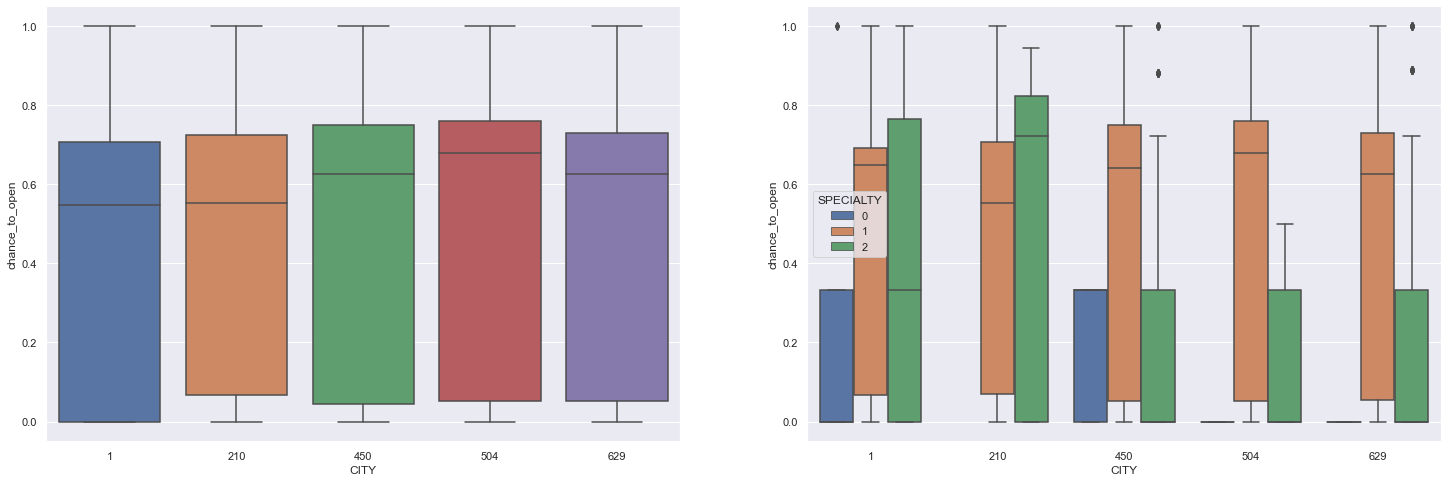

In [147]:
# проанализируем влияние на шанс открытия письма в зависимости от города клиента на топ-5 городах по количеству стилистов
Top_city_df = final_df[["CITY","SPECIALTY","chance_to_open"]].loc[final_df.CITY.isin(Top_city)]

fig, axs = plt.subplots(1,2)
sns.boxplot(data=Top_city_df, x="CITY", y="chance_to_open", ax=axs[0])
sns.boxplot(data=Top_city_df, x="CITY", y="chance_to_open", hue="SPECIALTY", ax=axs[1])
# распределения вероятности примерно равны для разных городов, есть различия - но они не столь существенны, как влияние которое оказывает специализация работников. 
# Можем исключить города и регионы из предсказательной модели.

In [148]:

features_df = final_df.drop(columns=["date_send","ASSET_ID","ACTIVITY_DATE_x","REGION1","REGION2","REGION3","CITY","ID_mail_company","CURRENT_STATUS","send_mail","open_mail"])

In [149]:
# выделяем категориальные переменные
categorical_var = features_df[["BRANDS","KEY_MESSAGE","CONTENT_TYPE","SEGMENT"]].columns.to_list()
encode_df = features_df.copy()
features_df

,CONTACT_ID,weekday_send,hour_send,BRANDS,KEY_MESSAGE,CONTENT_TYPE,SPECIALTY,SEGMENT,chance_to_open,target
0,8209529d-5f2f-41da-9f5d-995e1ba204cc,0,6,A,Other,Engagement,2,no segment,0.722,0
1,8209529d-5f2f-41da-9f5d-995e1ba204cc,0,7,A,Other,Education,2,no segment,0.722,0
2,8209529d-5f2f-41da-9f5d-995e1ba204cc,2,11,A,Other,Education,2,no segment,0.722,0
3,8209529d-5f2f-41da-9f5d-995e1ba204cc,4,7,A,Other,Education,2,no segment,0.722,0
4,8209529d-5f2f-41da-9f5d-995e1ba204cc,1,8,A,Efficacy,Education,2,no segment,0.722,1
...,...,...,...,...,...,...,...,...,...,...
82092,9833acfb-28bb-4106-a655-ea4e0432d086,4,6,R,Other,Education,2,D2,0.000,0
82093,9833acfb-28bb-4106-a655-ea4e0432d086,1,14,R,Other,Education,2,D2,0.000,0
82094,6bd687fb-f629-41f1-8aef-97b2e661d054,4,8,"R, OD, O",Other,Awareness,2,no segment,0.333,0
82095,6bd687fb-f629-41f1-8aef-97b2e661d054,4,6,R,Other,Education,2,no segment,0.333,0


In [150]:
#features_df["log_chance"] = np.log(features_df.chance_to_open/(1-features_df.chance_to_open))


In [151]:
# введем сглаженный ctr вместо шанса открытия для каждого юзера - чтобы ограничить влияние тех у кого мало посланных писем, 
# так как их статистика не точна изза малого количества экспериментов
def smoothed_ctr(send_mail, open_mail, global_ctr, a):
  smoothed_ctr = (open_mail + a*global_ctr)/(send_mail + a)
  return round(smoothed_ctr,3)

In [152]:
global_ctr = final_df.open_mail.sum()/final_df.send_mail.sum()
features_df['smoothed_ctr'] = smoothed_ctr(final_df.send_mail, final_df.open_mail,global_ctr, 5)

<AxesSubplot:xlabel='smoothed_ctr', ylabel='Count'>

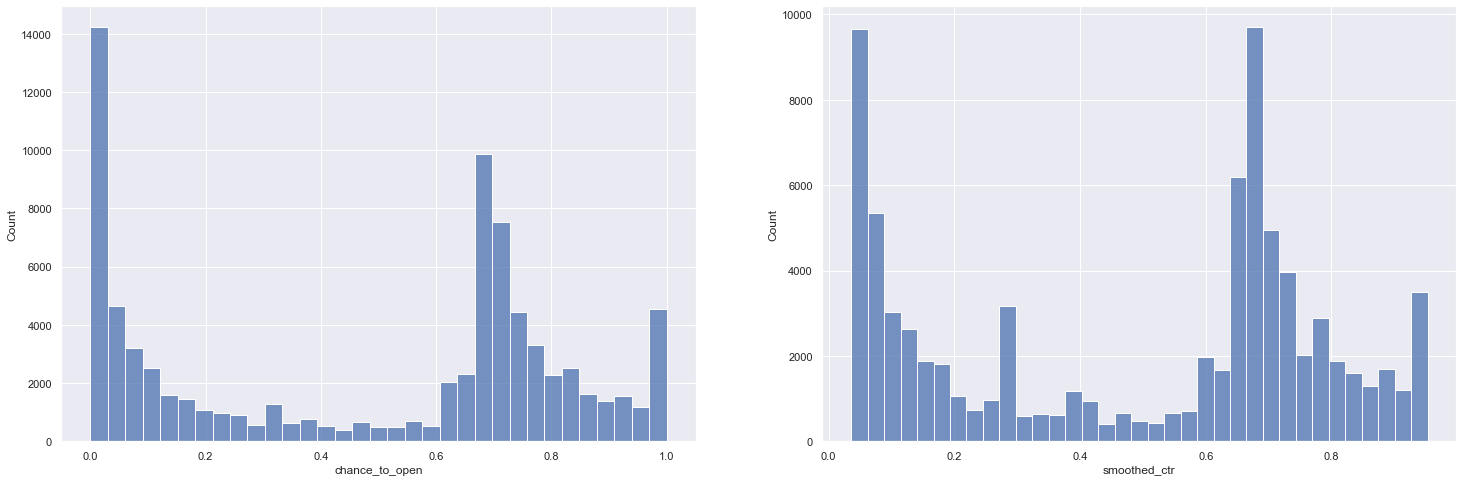

In [153]:
fig, axs = plt.subplots(1,2)
sns.histplot(features_df, x="chance_to_open", ax=axs[0])
sns.histplot(features_df, x="smoothed_ctr", ax=axs[1])


<AxesSubplot:xlabel='weekday_send', ylabel='chance_to_open'>

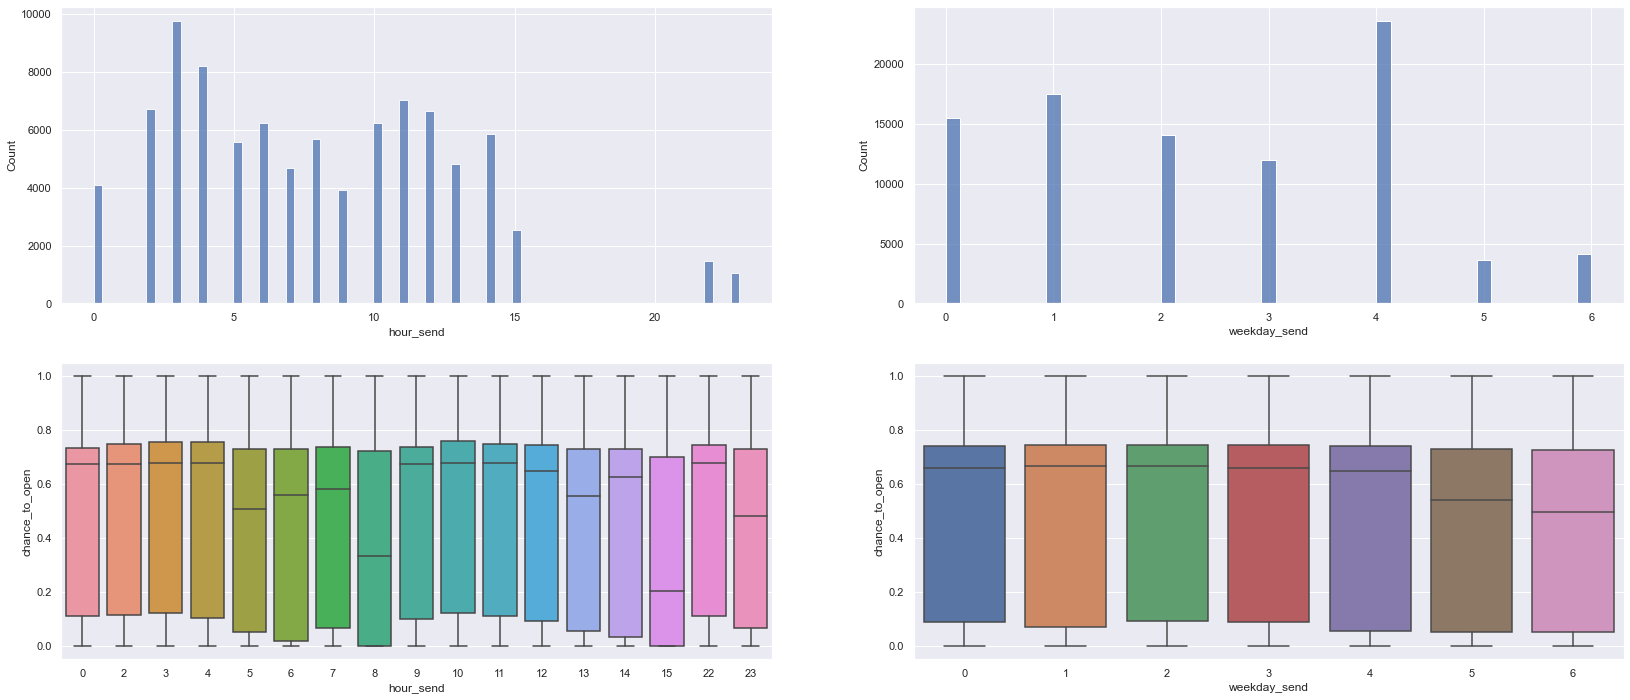

In [154]:
# ПРОАНАЛИЗИРУЕМ ВЛИЯНИЕ ВРЕМЕНИ И ДНЯ НЕДЕЛИ
sns.set(rc={'figure.figsize':(28,12)})
fig, axs = plt.subplots(2, 2)
# Большая часть писем приходит в первую половину дня - как ни странно, пик приходится на 3 часа ночи, в остальное время до 3 часов дня примерно одинаковая рассылка 
# позже практически нет писем. Вероятность открытия менее 50% с 5 до 8 утра, а также в 15 дня - возможно стоит уменьшить количество писем в это время.
sns.histplot(data=company_mail_send, x="hour_send", ax=axs[0,0])
# В целом видно, что больше всего писем шлют в пятницу, по выходным в 3-4 раза меньше чем по будням. Шансы открытия писем примерно одинаковы по будням, снижаются по выходным.
sns.histplot(data=company_mail_send, x="weekday_send", ax=axs[0,1])
sns.boxplot(data=features_df, x="hour_send", y="chance_to_open", ax=axs[1,0])
sns.boxplot(data=features_df, x="weekday_send", y="chance_to_open", ax=axs[1,1])

<AxesSubplot:xlabel='hour_send', ylabel='chance_to_open'>

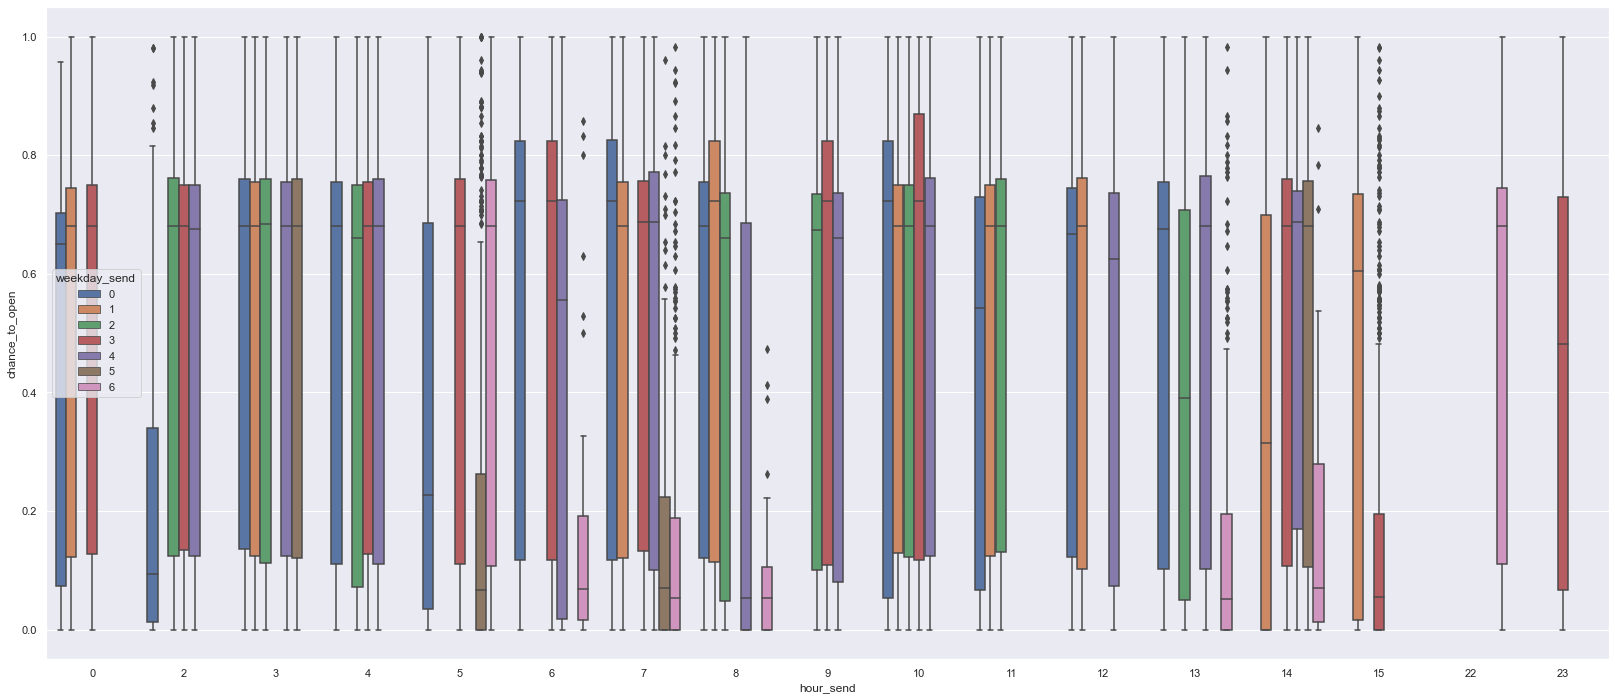

In [155]:
# в понедельник (2 и 5 часов), вторник (14 часов), в среду (13 часов), четверг (15 и 23 часов), пятницу (8 часов), субботу (5 и 7 часов), 
# воскресенье (6-8, 13-14 часов) - наблюдается резкое падение вероятности открытия писем, стоит скорректировать посылку в это время.
sns.boxplot(data=features_df, x="hour_send", y="chance_to_open", hue="weekday_send")

<AxesSubplot:xlabel='chance_to_open', ylabel='Count'>

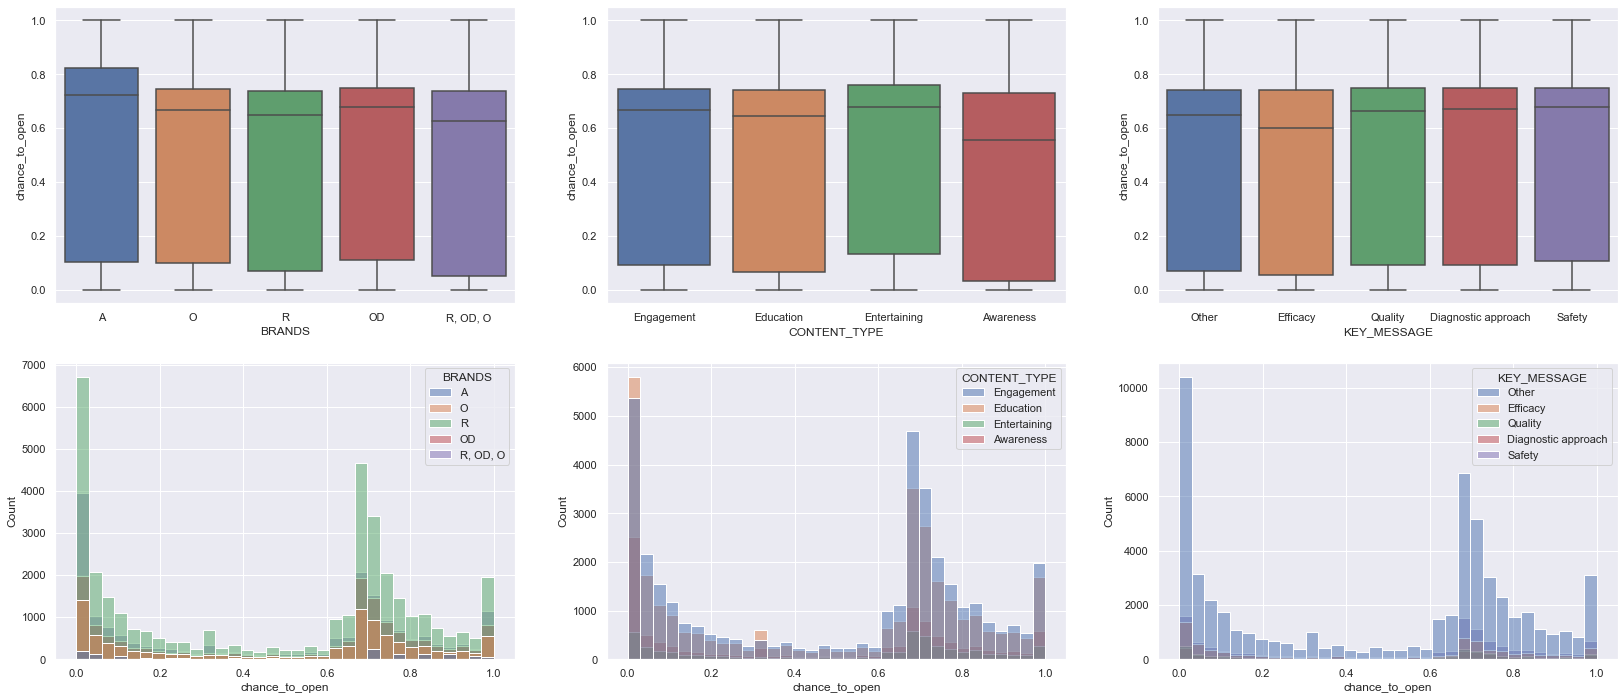

In [156]:
# ПРОАНАЛИЗИРУЕМ ВЛИЯНИЕ БРЕНДА, ТИПА КОНТЕНТА И КЛЮЧЕВОГО СООБЩЕНИЯ
fig, axs = plt.subplots(2, 3)
# письма по бренду А открывают чаще остальных, реже всех  колаборацию (R, OD, O)
sns.boxplot(data=features_df, x="BRANDS", y="chance_to_open", ax=axs[0,0])
# письма Awareness (информационной направленности) значительно реже открывают (медиана в среднем ниже на 12%), чаще всего открывают Entertaining(развлекательные) и Engagement(договорные) письма
sns.boxplot(data=features_df, x="CONTENT_TYPE", y="chance_to_open", ax=axs[0,1])
# в среднем медианы и квантили одинаковы для всех типов ключевых сообщений, за исключением Efficacy (письма о повышении качества явно реже открывают), 
sns.boxplot(data=features_df, x="KEY_MESSAGE", y="chance_to_open", ax=axs[0,2])
# преобладают письма косательно следующих брендов R, A, OD - учитывая высокий уровень вероятности открытия письма по этим брендам, решение хорошее. 
sns.histplot(data=features_df, x="chance_to_open", hue='BRANDS', ax=axs[1,0])
# преобладают Education(образовательные письма), а также Engagement (договорные для заключения контрактов), затем Awareness(информационные) - учитывая относительно 
# низкий уровень шансов для информационных писем, возможно стоит снизить их количество.
sns.histplot(data=features_df, x="chance_to_open", hue='CONTENT_TYPE', ax=axs[1,1])
# многократно преобладает количество писем other (без четкого ключегого сообщения), следом идут Safety(письма о безопасности) 
# учитывая высокий уровень вероятности открытия для этих групп - хорошее решение.
sns.histplot(data=features_df, x="chance_to_open", hue='KEY_MESSAGE', ax=axs[1,2])


<AxesSubplot:xlabel='chance_to_open', ylabel='Count'>

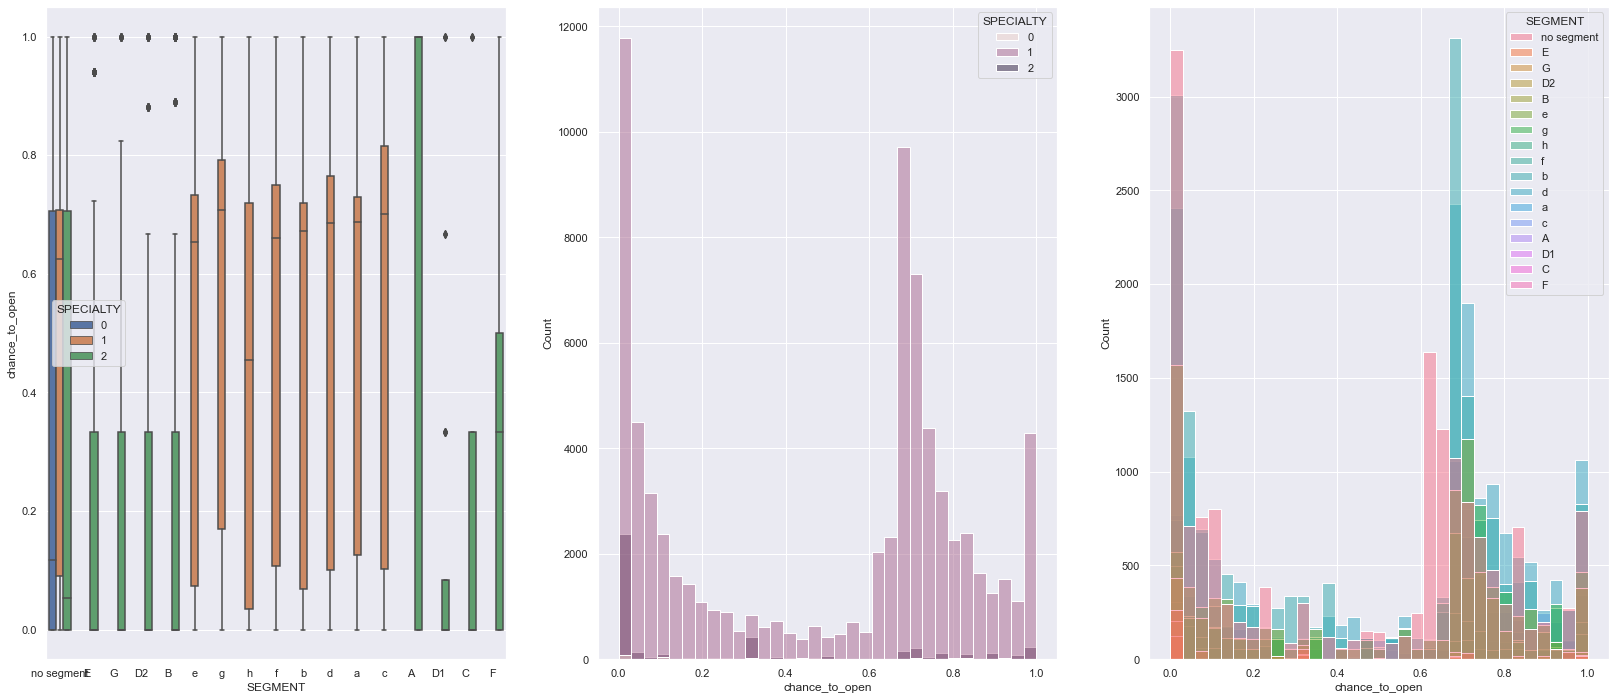

In [157]:
#|ПРОАНАЛИЗИРУЕМ ВЛИЯНИЕ СПЕЦИАЛИЗАЦИИ-СЕГМЕНТА
# наибольшая вероятность открытия письма у SPECIALTY 1, а учитывая что это самый распространенный тип писем - в них стоит вкладываться! 
# Шанс открытия письма для сегмента "no segment" и SPECIALTY 0,2 - самый низкий, а учитывая большое количество писем "no segment" это большие затраты, без ощутимой пользы.  
fig, axs = plt.subplots(1, 3)

sns.boxplot(data=features_df, x="SEGMENT", y="chance_to_open", hue="SPECIALTY", ax=axs[0])

sns.histplot(data=features_df, x="chance_to_open", hue='SPECIALTY', ax=axs[1])

sns.histplot(data=features_df, x="chance_to_open", hue='SEGMENT', ax=axs[2])


<AxesSubplot:xlabel='chance_to_open', ylabel='Count'>

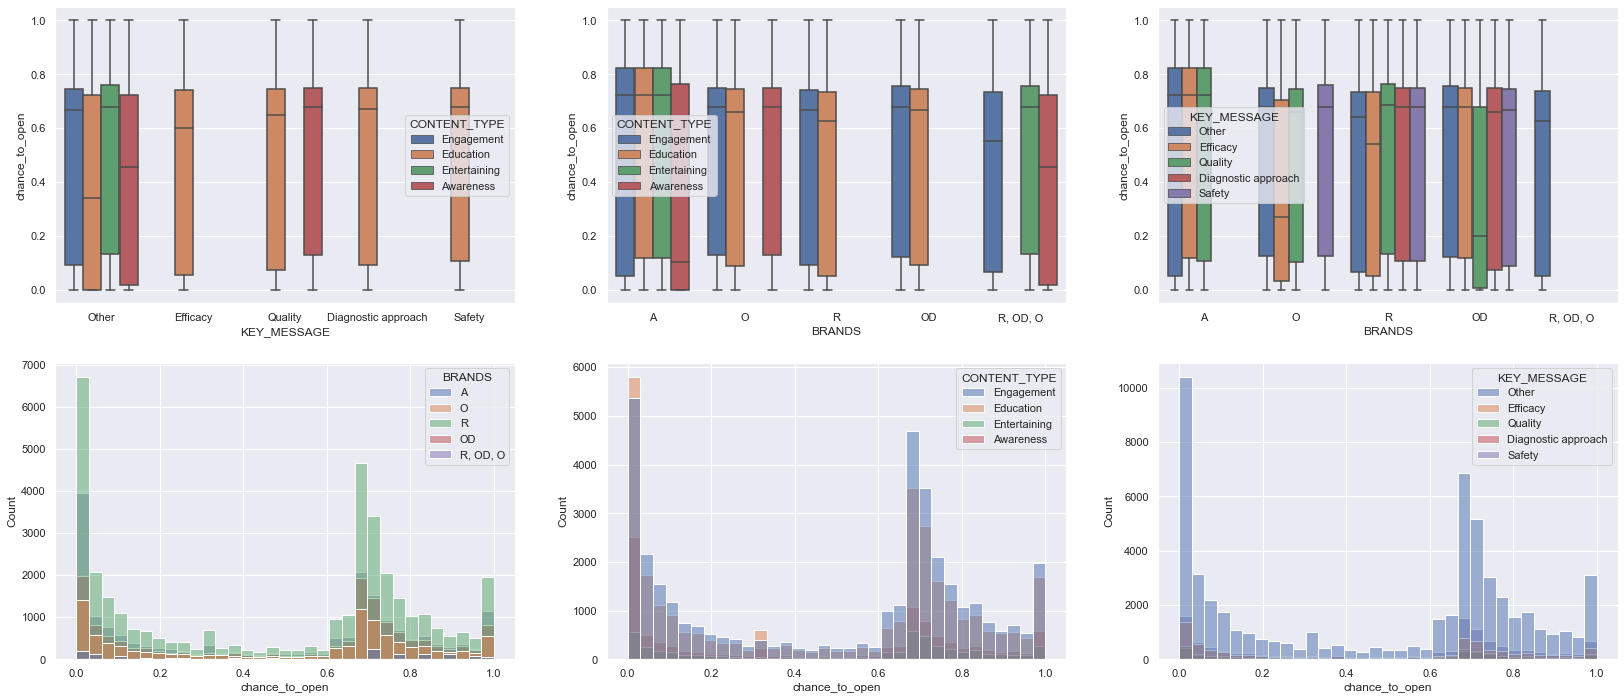

In [158]:
# ПРОАНАЛИЗИРУЕ ВЛИЯНИЕ КОМБИНИРОВАННЫХ ФАКТОРОВ (БРЕНД-ТИП КОНТЕНТА-КЛЮЧЕВОЕ СООБЩЕНИЕ)
# стоит отметить, что Education (образовательные) и Awareness (информационные) письма с ключевым словом "other" -  редко открывают (медиана в районе 40%), 
# а учитывая их распространенность это приводит к финансовым потерям (стоит точнее указывать ключевое слово сообщения)
fig, axs = plt.subplots(2, 3)
sns.boxplot(data=features_df, x="KEY_MESSAGE", y="chance_to_open", hue="CONTENT_TYPE", ax=axs[0,0])

# заметны колоссально низкие показатели вероятности у Awareness(информационных) писем для брэндов A, что при высоком количестве писем очень не выгодно!
# чуть выше для конгламерата R,OD,O - по этому типу писем относительно не много, не столь страшно...
# Также можно отметить не очень высокие шансы у Engagement(договорных) писем для брендов конгламерата R,OD,O
sns.boxplot(data=features_df, x="BRANDS", y="chance_to_open", hue="CONTENT_TYPE", ax=axs[0,1])

# Явно видно низкую вероятность открытия писем с ключевым словом Efficacy(эффективность) для бренда О и Quality(качество) для OD 
# Также средние не высокие шансы у писем с ключевым словом Efficacy(эффективность) для бренда R
sns.boxplot(data=features_df, x="BRANDS", y="chance_to_open", hue="KEY_MESSAGE", ax=axs[0,2])

sns.histplot(data=features_df, x="chance_to_open", hue='BRANDS', ax=axs[1,0])
sns.histplot(data=features_df, x="chance_to_open", hue='CONTENT_TYPE', ax=axs[1,1])
sns.histplot(data=features_df, x="chance_to_open", hue='KEY_MESSAGE', ax=axs[1,2])

In [159]:
# декодируем one hot encoding
def encode_and_bind(original_dataframe, feature_to_encode):
    dummies = pd.get_dummies(original_dataframe[feature_to_encode])
    res = pd.concat([original_dataframe, dummies], axis=1)
    return(res.drop(feature_to_encode, axis=1))

encode_df = encode_and_bind(encode_df,categorical_var)

In [160]:
# разделяем на предикторы и зависимую метрику
X = encode_df.drop(["chance_to_open","target"], axis=1)
y = encode_df.target

In [161]:
# Делим выборку на train и test, все метрики будем оценивать на тестовом датасете

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y,  test_size=0.33, random_state=42)
train_ID = X_train['CONTACT_ID']
test_ID = X_test['CONTACT_ID']
X_train.drop(['CONTACT_ID'], axis=1, inplace=True)
X_test.drop(['CONTACT_ID'], axis=1, inplace=True)


In [165]:
# 
y_test.value_counts()

0    18533
1     8560
Name: target, dtype: int64